# Variogram Model
#### Mickey MacKie, Stanford Radio Glaciology

Here we fit a variogram model to the experimental variogram calculated in the Experimental_Variogram.ipynb example. Why fit a parametric variogram model to the experimental variogram? First of all, we need a way to interpolate variance estimates to all lag distances. Second, a variogram must satisfy certain mathematical properties in order to be used in kriging and stochastic simulation. This is covered in the Simple_Kriging.ipynb notebook.

The parameters of a variogram model are the nugget, sill, and range. The nugget or y-intercept represents small scale variability. Some of the nugget effect could be attributed to measurement error. The range is the lag distance where the variogram levels off. This means that two points separated by a lag distance greater than or equal to the range are not spatially correlated. The sill is the maximum variability between two points. When working with data that has been transformed to a standard Gaussian distribution, the sill is 1. 
The shape of the variogram is usually described by spherical, exponential, and Gaussian models. Variogram models can be a function of more than one model.

<img src ="Images/variogram.png" width="400">

On a side note, there are a number of excellent open source variogram modeling functions. However, we defined our own in order to give ourselves greater flexibility when working on more complex problems.

In [1]:
# load dependencies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
 
import geostatspy.geostats as geostats 

import GlacierStats as gs

## Load and plot data

<function matplotlib.pyplot.show(*args, **kw)>

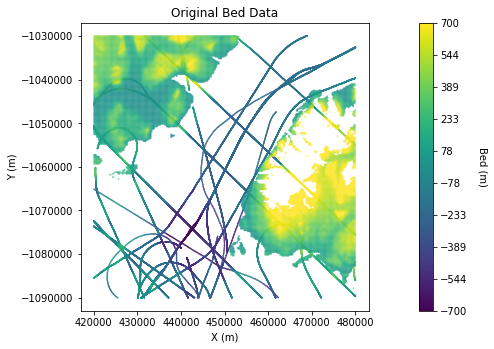

In [2]:
df_bed = pd.read_csv('Data/Nioghalvfjerds_bed_data.csv') # download data

# plot original data
im = plt.scatter(df_bed['X'],df_bed['Y'], c = df_bed['Bed'], vmin = -700, vmax = 700, marker=".", s = 0.5)       # scatter plot for location map
plt.title('Original Bed Data')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-700, 700, 10)) # add vertical color bar
cbar.set_label("Bed (m)", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')
plt.show

## Normal score transformation and experimental variogram

In [3]:
df_bed['Nbed'], tvbed, tnsbed = geostats.nscore(df_bed,'Bed')  # normal score transformation

# randomly downsample data to 10% of the original size
df_samp = df_bed.sample(frac=0.10, replace=True, random_state=1)

# experimental variogram parameters
tmin = -9999.; tmax = 9999.;  # limits
lag_dist = 2000.0 # lag distance interval (in meters)
lag_tol = 100.0 # lag tolerance
nlag = 20 # number of lag distances to use
isill = 1 # no effect for normal score transformed data
bandh = 50 # bandwidth tolerance
azi_mat = [0,22.5,45,67.5,90,112.5,135,157.5]           # directions in azimuth to consider
atol = 10 # 10 degree tolerance

# Arrays to store the results
lag = np.zeros((len(azi_mat),nlag+2)); gamma = np.zeros((len(azi_mat),nlag+2)); npp = np.zeros((len(azi_mat),nlag+2));

# variogram
for iazi in range(0,len(azi_mat)):  # Loop over all directions to get variograms
    lag[iazi,:], gamma[iazi,:], npp[iazi,:] = geostats.gamv(df_samp,"X","Y","Nbed",tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)

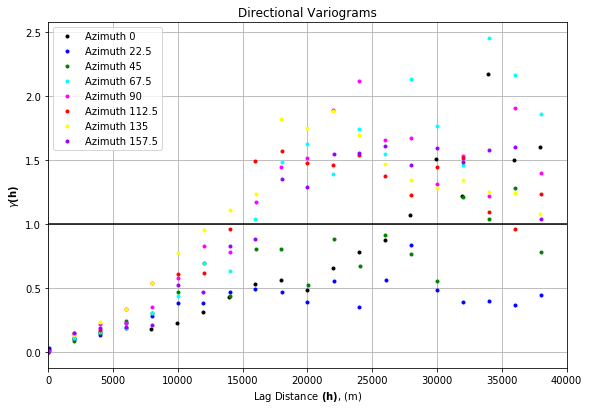

In [4]:
# plot anistropic variograms
plt.plot(lag[0,:],gamma[0,:],'.',color = 'black',label = 'Azimuth 0')
plt.plot(lag[1,:],gamma[1,:],'.',color = 'blue',label = 'Azimuth 22.5')
plt.plot(lag[2,:],gamma[2,:],'.',color = 'green',label = 'Azimuth 45')
plt.plot(lag[3,:],gamma[3,:],'.',color = 'cyan',label = 'Azimuth 67.5')
plt.plot(lag[4,:],gamma[4,:],'.',color = 'magenta',label = 'Azimuth 90')
plt.plot(lag[5,:],gamma[5,:],'.',color = 'red',label = 'Azimuth 112.5')
plt.plot(lag[6,:],gamma[6,:],'.',color = 'yellow',label = 'Azimuth 135')
plt.plot(lag[7,:],gamma[7,:],'.',color = '#9900ff',label = 'Azimuth 157.5')
plt.plot([0,40000],[1.0,1.0],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional Variograms')
plt.xlim([0,40000])
plt.legend(loc='upper left')
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.1, hspace=0.2) # adjust the plot size
plt.show()

## Fit variogram model

First, let's identify the major and minor axes. These should be orthogonal to each other. The major axis is smoothest direction, which is often parallel to ice flow direction. The minor axis is usually transverse to ice flow. By looking at the directional variograms, we can identify a major axis of 22.5 degrees (blue), and a minor axis of 112.5 (red).

Next, we can estimate the range for the major and minor axes. For the major axis, the variogram first gets close to 1 at approximately 27000 meters. For the minor axis, this happens around 14000. 

The available variogram shapes are spherical (1), exponential (2), and Gaussian (3). We'll start with an exponential shape.

Let's test these parameters in a model:

In [5]:
# set variogram parameters
n = 100
lagh = np.linspace(0,40000,n) # create array of evenly spaced lag values to evaluate
Directions = ["Major", "Minor"]

nug = 0 # nugget
nstruct = 1 # variogram structures 
vtype = [1] # exponential type (1 = spherical, 2 = exponential, 3 = Guassian)
cc = [1] # nugget + cc = 1
a_max = [27000]
a_min = [14000]

major_model = gs.axis_var(lagh, nug, nstruct, cc, vtype, a_max)
minor_model = gs.axis_var(lagh, nug, nstruct, cc, vtype, a_min)

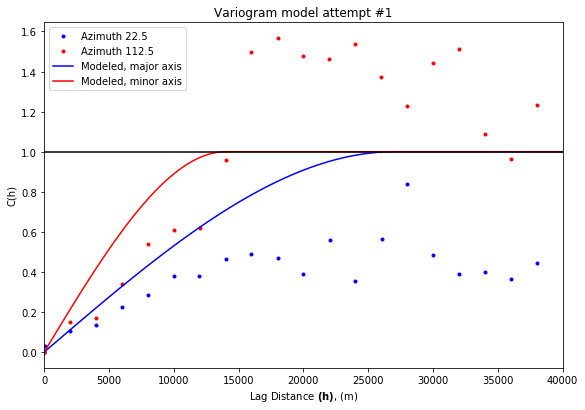

In [6]:
# plot modeled covariance functions
plt.plot(lag[1,:],gamma[1,:],'.',color = 'blue',label = 'Azimuth 22.5')
plt.plot(lag[5,:],gamma[5,:],'.',color = 'red',label = 'Azimuth 112.5')
plt.plot(lagh,major_model,'-',color = 'blue',label = 'Modeled, major axis')
plt.plot(lagh,minor_model,'-',color = 'red',label = 'Modeled, minor axis')
plt.plot([0,40000],[1,1],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel('C(h)')
plt.title('Variogram model attempt #1')
plt.xlim([0,40000])
plt.legend(loc='upper left')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.1, hspace=0.2) # adjust the plot size
plt.show()

Ok, let's keep tweaking. Next we increase the range and use a two structure variogram model: 

In [8]:
# set variogram parameters
n = 100
lagh = np.linspace(0,40000,n) # create array of evenly spaced lag values to evaluate
Directions = ["Major", "Minor"]

nug = 0 # nugget
nstruct = 2 # variogram structures
vtype = [1,2] # exponential type (1 = spherical, 2 = exponential, 3 = Guassian)
cc = [0.8,0.2] # contribution for each structure. nugget + cc = 1
a_max = [40000,50000] # major range for each structure
a_min = [25000,30000] # minor range for each structure

major_model = gs.axis_var(lagh, nug, nstruct, cc, vtype, a_max)
minor_model = gs.axis_var(lagh, nug, nstruct, cc, vtype, a_min)

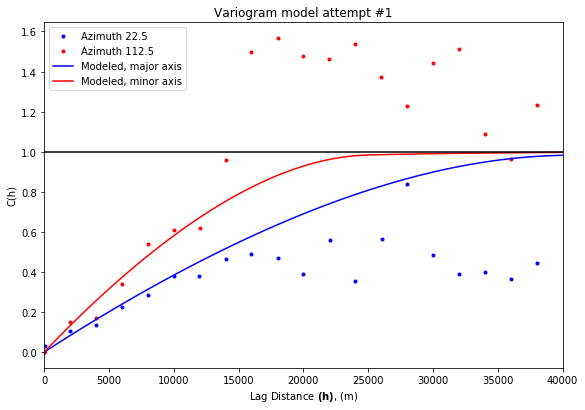

In [9]:
# plot modeled covariance functions
plt.plot(lag[1,:],gamma[1,:],'.',color = 'blue',label = 'Azimuth 22.5')
plt.plot(lag[5,:],gamma[5,:],'.',color = 'red',label = 'Azimuth 112.5')
plt.plot(lagh,major_model,'-',color = 'blue',label = 'Modeled, major axis')
plt.plot(lagh,minor_model,'-',color = 'red',label = 'Modeled, minor axis')
plt.plot([0,40000],[1,1],color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel('C(h)')
plt.title('Variogram model attempt #1')
plt.xlim([0,40000])
plt.legend(loc='upper left')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.1, hspace=0.2) # adjust the plot size
plt.show()

Keep in mind that you should prioritize model fit for small lags. This is because geostatistical inteprolation algorithms such as kriging put more weight on nearby points than distant points. Once we've determined the variogram parameters, we can use it to perform interpolations.